In [ ]:
%pip install -Uq "unstructured[pdf]" pillow lxml
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv
%pip install unstructured

In [ ]:
import os

# keys for the services we will use

os.environ["OPENAI_API_KEY"] = "sk-..."
os.environ["GROQ_API_KEY"] = "sk-..."
os.environ["LANGCHAIN_API_KEY"] = "sk-..."
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
output_path = "./content/"
# file_path = output_path + 'attention.pdf'
file_path = output_path + 'product.pdf'
print(file_path)

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

In [3]:
# import os
from unstructured.partition.pdf import partition_pdf

# Set the Poppler path environment variable
# os.environ["POPPLER_PATH"] = r"C:\Program Files\poppler\poppler-24.08.0\Library\bin"

# Define your file path and output path
output_path = "content/"
file_path = output_path + 'product.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
try:
    chunks = partition_pdf(
        filename="content/product.pdf",
        infer_table_structure=True,            # extract tables
        strategy="hi_res",                     # mandatory to infer tables

        extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
        # image_output_dir_path=output_path,   # if None, images and tables will be saved in base64

        extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

        chunking_strategy="by_title",          # or 'basic'
        max_characters=300,                  # defaults to 500
        combine_text_under_n_chars=100,       # defaults to 0
        new_after_n_chars=400,

        poppler_path=r"C:\Program Files\poppler\poppler-24.08.0\Library\bin",  # Specify poppler_path here

        # extract_images_in_pdf=True,          # deprecated
    )
except FileNotFoundError as e:
    print(e)
    raise

# Optionally, print the chunks or process them as needed
for chunk in chunks:
    print(chunk)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wonderful Oddities Shop- The Oddities Collection
Step into the Wonderful Oddities Shop, a place where the mysterious and the enchanted intertwine. Tucked away in a forgotten alley, this shop offers rare artifacts imbued with magic, each carrying its own secrets and curses. Browse with caution—every item has a story, and some may change yours
forever.
ChronoLens Camera (Standard Edition)

e A beautifully aged polaroid camera wrapped in cracked leather, its buttons cold to the touch.

e When you take a picture, the film develops into a moment in time—not the present, but either past or future.
e A faint humming sound echoes before the image reveals itself.

e 2,000SGD

| ChronoLens Camera (Standard Edition)

ChronoLens Camera (Standard Edition)

ChronoLens Camera (Limited Edition)

e Prints moving ghostly images—a scene unfolding before your eyes.
e Ifthe photo develops in red hues, you have witnessed a moment fated to change your life forever.

e The camera occasionally trembles in your

In [4]:
# We get 2 types of elements from the partition_pdf function
# set([str(type(el)) for el in chunks])

len(chunks)
# chunks[3].metadata.orig_elements

27

In [ ]:
for ch in chunks[5].metadata.orig_elements:
    if "Table" in str(type(ch)):
        print (ch)

In [ ]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

tables=[]
# chunks[3].metadata.orig_elements

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

In [ ]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

### Separate extracted elements into tables, text, and images

In [5]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

texts = [element.text for element in texts]  # Adjust this depending on the structure of your CompositeElement.

In [6]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

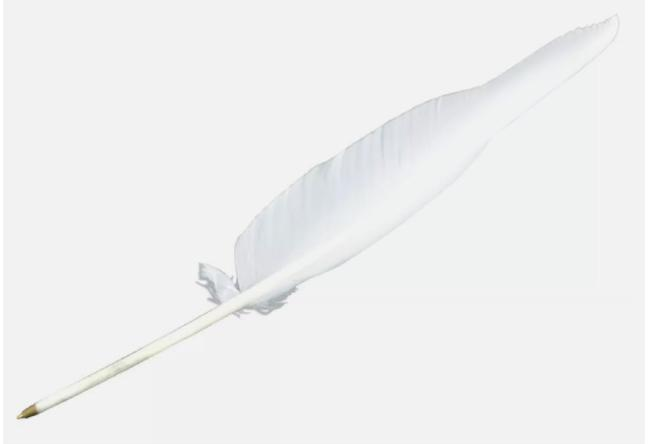

In [9]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[8])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [ ]:
%pip install -Uq langchain-groq

In [11]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [14]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing text.
Give a concise summary of the text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [15]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# # Summarize tables
# tables_html = [table.metadata.text_as_html for table in tables]
# table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [ ]:
%pip install -Uq langchain_openai

In [16]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is exactly the product that being sold in the wonderful oddities shop
                  """
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [17]:
text_summaries

['The Wonderful Oddities Shop is home to "The Oddities Collection", a unique and fascinating accumulation of strange and unusual items.',
 "The Wonderful Oddities Shop, a mysterious store in a forgotten alley, sells rare magical artifacts with secrets and potential curses, each with its own story that may alter the buyer's life.",
 'The concept of "forever" refers to a state or period without end, often used to describe eternity or infinity.',
 'The ChronoLens Camera is a unique, aged polaroid camera that captures moments in time, but not the present, instead showing either the past or future.',
 'A mysterious humming sound precedes the appearance of a ghostly image, revealing a scene in motion.',
 "The ChronoLens Camera, a limited edition item, costs 3,500SGD and is said to capture life-changing moments, with its occasional trembling indicating it's revealing secrets.",
 'The ChronoLens Camera (Cursed Edition) takes photographs with a shadowy figure present, which appears closer in ea

## Load data and summaries to vectorstore

### Create the vectorstore

In [20]:
import uuid
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag_testing", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
    search_kwargs={"k": 4} 
)

### Load the summaries and link the to the original data

In [21]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# # Add tables
# table_ids = [str(uuid.uuid4()) for _ in tables]
# summary_tables = [
#     Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
# ]
# retriever.vectorstore.add_documents(summary_tables)
# retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

## Qdrant (outdated)

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, HnswConfig

qdrant_client = QdrantClient()

collection_name = "your_collection_name"

vectors_config = {
    "embedding": VectorParams(
        size=1536,  # Set the correct vector size for OpenAI embeddings
        distance="Cosine",  # or "Euclidean" depending on your use case
    )
}

print(f"Creating collection {collection_name} with the correct configuration.")
qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=vectors_config
)


In [ ]:
qdrant_client.delete_collection(collection_name=collection_name)


In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import HnswConfigDiff

qdrant_client = QdrantClient()

# Update the collection with new HNSW configuration
qdrant_client.update_collection(
    collection_name=collection_name,
    vectors_config={
        "embedding": {
            "hnsw_config": HnswConfigDiff(
                ef_construct=200,  # Correct field name for ef_construction
                m=16,
                full_scan_threshold=100  # Add the missing field
            )
        }
    }
)

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct
from sklearn.decomposition import PCA

# Initialize Qdrant client
qdrant_client = QdrantClient("http://localhost:6333")  # Replace with your Qdrant instance URL
collection_name = "your_collection_name"

# Initialize the OpenAI Embeddings model
embedding_function = OpenAIEmbeddings()

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embedding_function)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Generate document IDs for text and image data
doc_ids = [str(uuid.uuid4()) for _ in texts]
img_ids = [str(uuid.uuid4()) for _ in images]

# Generate embeddings for texts using OpenAIEmbeddings
def generate_text_embeddings(texts):
    return embedding_function.embed_documents(texts)

# Function to reduce dimensionality of embeddings to 512 using PCA
def reduce_dimensionality(embeddings, target_dim=512):
    n_samples, n_features = len(embeddings), len(embeddings[0]) if embeddings else 0
    
    if n_samples == 0 or n_features == 0:
        raise ValueError("Embeddings are empty or improperly formatted.")
    
    # Ensure n_components does not exceed min(n_samples, n_features)
    n_components = min(target_dim, min(n_samples, n_features))

    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

# Function to store embeddings and metadata in Qdrant
def store_embeddings_in_qdrant(doc_ids, embeddings, summaries, texts=None, images=None):
    points = [
        PointStruct(
            id=doc_id,
            vector={"embedding": embedding},  # Ensure correct vector name
            payload={"summary": summary, "text": text, "image": image}
        )
        for doc_id, embedding, summary, text, image in zip(doc_ids, embeddings, summaries, texts or [None] * len(doc_ids), images or [None] * len(doc_ids))
    ]
    
    # Upload the points into the Qdrant collection
    qdrant_client.upsert(collection_name=collection_name, points=points)

# Add texts to retriever (store texts and summaries in vectorstore)
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Generate embeddings for texts
text_embeddings = generate_text_embeddings(texts)  # Generate embeddings for texts

# Optionally reduce the dimensionality of the text embeddings to 512 if needed
text_embeddings_512 = reduce_dimensionality(text_embeddings, target_dim=512)

# Store embeddings and metadata in Qdrant for text summaries
store_embeddings_in_qdrant(doc_ids, text_embeddings, text_summaries, texts=texts)

# Add image summaries to retriever
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

# Generate embeddings for images using a different model (e.g., CLIP)
# This is a placeholder function. Replace with actual image embedding logic.
def generate_image_embeddings(images):
    # Placeholder: Replace with actual image embedding logic
    return [[0.0] * 512 for _ in images]  # Example: Dummy embeddings with 512 dimension

def pad_image_embeddings(image_embeddings, target_dim=1536):
    return [embedding + [0.0] * (target_dim - len(embedding)) for embedding in image_embeddings]



# Generate embeddings for images
image_embeddings = generate_image_embeddings(images)  # Generate embeddings for images

# Pad image embeddings to 1536 dimensions
image_embeddings_1536 = pad_image_embeddings(image_embeddings, target_dim=1536)

# Store embeddings and metadata in Qdrant for image summaries
store_embeddings_in_qdrant(img_ids, image_embeddings_1536, image_summaries, images=images)


## Chroma (latest)

In [62]:
# testing for connectivity to chromadb
import chromadb
client = chromadb.HttpClient(host="chromadb", port=8000)

# Try listing collections or a simple operation
print(client.list_collections())

print("--------------------")
collection = client.get_collection(name="multi_modal_rag_testing")

# # Query documents in your collection
# results = collection.query(
#     query_texts=["your query text here"],  # Or use query_embeddings=
#     n_results=5
# )

# # Print the results
# print("Query Results:", results)



[Collection(name=multi_modal_rag_testing), Collection(name=multi_modal_rag)]
--------------------


In [23]:
# old function (outdated)
import uuid
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.storage._lc_store import create_kv_docstore
from langchain.storage import LocalFileStore
from langchain.schema import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
import chromadb
from chromadb.config import Settings  # ✅ Import Settings
from sklearn.decomposition import PCA

# Initialize OpenAI Embeddings
embedding_function = OpenAIEmbeddings()

# ✅ Explicitly connect to the running ChromaDB server
chroma_client = chromadb.HttpClient(
    host="localhost",  # Docker container name
    port=8000
)

persist_directory = "./chroma_db"

vectorstore = Chroma(
    client=chroma_client,  
    collection_name="multi_modal_rag_testing",
    embedding_function=embedding_function,
    # persist_directory=persist_directory  # ✅ Match Docker volume mount
)

fs = LocalFileStore("./store_document_testing")
docstore = create_kv_docstore(fs)


# The storage layer for parent documents
id_key = "doc_id"

# Initialize the retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
    search_kwargs={"k": 4} 
)

# Generate unique document IDs
doc_ids = [str(uuid.uuid4()) for _ in texts]
img_ids = [str(uuid.uuid4()) for _ in images]

# Generate text embeddings
def generate_text_embeddings(texts):
    return embedding_function.embed_documents(texts)

# Store embeddings and metadata in ChromaDB
def store_embeddings_in_chroma(doc_ids, embeddings, summaries, texts=None, images=None):
    documents = [
        Document(
            page_content=summary,
            metadata={
                "id": doc_id,
                "text": text if text is not None else "",  # Replace None with ""
                "image": image if image is not None else ""  # Replace None with ""
            }
        )
        for doc_id, embedding, summary, text, image in zip(
            doc_ids, embeddings, summaries,
            texts if texts is not None else [""] * len(doc_ids), 
            images if images is not None else [""] * len(doc_ids)
        )
    ]

    # Store in ChromaDB
    vectorstore.add_documents(documents)



# Add text summaries to retriever
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, [Document(page_content=text) for text in texts])))

# Generate and store text embeddings
text_embeddings = generate_text_embeddings(texts)  

store_embeddings_in_chroma(doc_ids, text_embeddings, text_summaries, texts=texts)

# Add image summaries to retriever
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, [Document(page_content=image) for image in images])))

# Placeholder function for generating image embeddings
def generate_image_embeddings(images):
    return [[0.0] * 512 for _ in images]  # Example: Dummy embeddings

# Ensure image embeddings match required dimensionality
def pad_image_embeddings(image_embeddings, target_dim=1536):
    return [embedding + [0.0] * (target_dim - len(embedding)) for embedding in image_embeddings]

# Generate and store image embeddings
image_embeddings = generate_image_embeddings(images)

store_embeddings_in_chroma(img_ids, image_embeddings, image_summaries, images=images)

print("✅ All data (vectors & documents) are now stored in ChromaDB!")

ModuleNotFoundError: No module named 'sklearn'

In [31]:
# Initialize OpenAI Embeddings
embedding_function = OpenAIEmbeddings()

chroma_client = chromadb.HttpClient(
    host="chromadb",  # Docker container name
    port=8000
)

persist_directory = "./chroma_db"

vectorstore = Chroma(
    client=chroma_client,  
    collection_name="multi_modal_rag_testing",
    embedding_function=embedding_function,
    # persist_directory=persist_directory  # ✅ Match Docker volume mount
)

fs = LocalFileStore("./store_document")
docstore = create_kv_docstore(fs)


# The storage layer for parent documents
id_key = "doc_id"

# Initialize the retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
    search_kwargs={"k": 4} 
)


# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
documents = [Document(page_content=text, metadata={id_key: doc_id}) for doc_id, text in zip(doc_ids, texts)]
retriever.docstore.mset(list(zip(doc_ids, documents)))

# # Add tables
# table_ids = [str(uuid.uuid4()) for _ in tables]
# summary_tables = [
#     Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
# ]
# retriever.vectorstore.add_documents(summary_tables)
# retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
image_documents = [Document(page_content=image, metadata={id_key: img_id}) for img_id, image in zip(img_ids, images)]
retriever.docstore.mset(list(zip(img_ids, image_documents)))

In [54]:
# # Check number of vectors in the collection
# num_vectors = vectorstore._collection.count()
# print(f"Number of vectors in ChromaDB collection: {num_vectors}")

# # Get all document IDs stored in the docstore
# doc_ids = list(docstore.yield_keys())

# # Print document count and a preview of some IDs
# print(f"Number of documents in docstore: {len(doc_ids)}")
# print("Sample document IDs:", doc_ids[:5])  # Show first 5 document IDs

retrieved_docs = retriever.invoke("what does Shadow Cloak (Cursed Edition) look like")

print(f"Number of retrieved documents: {len(retrieved_docs)}")
# print(dir(retrieved_docs[2]))
for doc in retrieved_docs:
    print(f"Document ID: {doc.metadata.get(id_key, 'Unknown')}")
    print(f"Content: {doc.page_content[:200]}...")  # Print first 200 characters
    print("-" * 80)


Number of retrieved documents: 4
Document ID: 67733e96-ce69-4952-a274-5262e60eb4bd
Content: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIy...
--------------------------------------------------------------------------------
Document ID: 43da5c39-3796-4006-94c4-05be7a531cdf
Content: e

e Use it too often, and one day, you will never return from the shadows.

e The cloak occasionally tightens on its own, as if reluctant to let go.

e 600 SGD

Shadow Cloak (Cursed Edition)

Hourgla...
--------------------------------------------------------------------------------
Document ID: f4671d45-fda5-4f96-896a-eb06af4d40b8
Content: another nearby.

e Occasionally, whispers from unseen figures are heard when worn.

3,000 SGD

Aad

Shadow Cloak

Shadow Cloak (Standard Edition)

Shadow Cloak (Limited Edition)

e A Purple cloak.

Gr...
----------------

In [36]:
chroma_client = chromadb.Client()

# Query documents in your collection
results = chroma_client.query(
    collection_name="multi_modal_rag_testing",
    query_embeddings=None,  # Optional: you can provide query embeddings if you want to filter based on similarity
    n_results=5  # Number of results you want to retrieve
)

# Print the results
print("Query Results:", results)

AttributeError: 'Client' object has no attribute 'query'

## RAG pipeline

In [67]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from base64 import b64decode


# Helper functions
def is_base64(s):
    try:
        return base64.b64encode(base64.b64decode(s)).decode() == s
    except Exception:
        return False

def parse_docs(docs):
    b64 = []
    text = []
    for doc in docs:
        if isinstance(doc.page_content, str) and is_base64(doc.page_content):
            b64.append(doc.page_content)
        else:
            text.append(doc.page_content)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]
    context_text = "\n".join(docs_by_type["texts"])
    prompt_template = f"""
    Answer the question based only on the following context.
    Context: {context_text}
    Question: {user_question}
    """
    prompt_content = [{"type": "text", "text": prompt_template}]
    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image}"}}
            )
    return ChatPromptTemplate.from_messages([HumanMessage(content=prompt_content)])


# Define RAG pipeline
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(RunnableLambda(build_prompt) | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser())
)


response = chain_with_sources.invoke(
    "what is the most expensive item in the shop"
)
# print("Response:", response)


print("Response:", response['response'])

print("\n\nContext:")
# for text in response['context']['texts']:
#     print(text.text)
#     print("Page number: ", text.metadata.page_number)
#     print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: The most expensive item in the shop is the ChronoLens Camera (Limited Edition), priced at 3,500 SGD.


Context:


### Check retrieval

In [55]:
# Retrieve
docs = retriever.invoke(
    "what is the picture of ChronoLens Camera (Limited Edi􀆟on)"
)

for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

page_content='/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFuAT0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDk9VvNY8LanNp0FxuG3cDLzj6ZqkPGmvgBvOhIPT5BXYfEuyX/AIS6coiti2QkEdiT/hXKJpsYmWNFAjaMSEA5A9B9aYEf/Caa+BtLwg+pQU5/GmvhzmSBQO+wYNSw6bBKd7BIyp2uHHGPen/2VGLUvGpUuc

In [39]:
len(docs)

4

In [56]:
response = chain.invoke(
    "what is the picture of ChronoLens Camera (Limited Edi􀆟on)"
)

print(response)

TypeError: can only concatenate str (not "Document") to str

In [48]:
response = chain_with_sources.invoke("what is the picture of ChronoLens Camera (Limited Edi􀆟on)")


print("Response:", response['response'])

print("\n\nContext:")
# for text in response['context']['texts']:
#     print(text.text)
#     print("Page number: ", text.metadata.page_number)
#     print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: The picture of the ChronoLens Camera (Limited Edition) is not provided in the context. It describes the camera features and pricing but does not include a visual representation or description of the image itself. The context highlights that this camera has a price of 3,500 SGD and mentions its potential to change your life forever along with a sense of mystery surrounding it.


Context:


In [43]:
vectorstore.similarity_search("what is the shop name?")

[Document(id='614a5a92-09e7-4e8c-948e-c49d4dddad99', metadata={'doc_id': '49071dbf-53bd-4426-a78a-2cd53ffc728c'}, page_content="The Wonderful Oddities Shop, a mysterious store in a forgotten alley, sells rare magical artifacts with secrets and potential curses, each with its own story that may alter the buyer's life."),
 Document(id='ff61446b-0f48-4b9b-baa9-8fae44341ebb', metadata={'doc_id': 'b2897883-f420-45ae-8837-4f3d4a02f9c4'}, page_content='The Wonderful Oddities Shop is home to "The Oddities Collection", a unique and fascinating accumulation of strange and unusual items.'),
 Document(id='cf564e6d-fa85-480c-bab5-ed4094b64424', metadata={'doc_id': 'f4671d45-fda5-4f96-896a-eb06af4d40b8'}, page_content='The Shadow Cloak is a clothing item that grants 13 minutes of true invisibility per night, available in standard and limited editions, priced at 3,000 SGD.'),
 Document(id='7103fcb5-fd4c-4096-8180-0d35c4102cca', metadata={'doc_id': '6d174030-d379-45ef-857c-ea55e4e65245'}, page_content